# KITTI Raw Dataset

> see dataset [link](http://www.cvlibs.net/datasets/kitti/eval_depth.php?benchmark=depth_prediction)      
> Note: I use this dataset for multi-view stereo depth prediction. Therefore, the depth label is the main thing I focus on.

## 1. Introduction

### 1.1 Sensor Setup

See the following figure 

<img src="../files/kitti-sensor-setup.png" alt="drawing" width="700"/>

### 1.2 Dataset Information

- See this main paper: [Vision meets Robotics: The KITTI Dataset](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf).
- The color cameras lack in terms of resolution due to the Bayer pattern interpolation process and are less sensitive to light. This is the reason why we use two stereo camera rigs, one for grayscale and one for color. The baseline of both stereo camera rigs is approximately 54 cm.
- The raw data set is divided into the categories ’Road’, ’City’, ’Residential’, ’Campus’ and ’Person’.
- For each sequence, we provide the raw data, object annotations in form of 3D bounding box tracklets and a calibration file, as illustrated in Fig. 4. 
- Our recordings have taken place on the 26th, 28th, 29th, 30th of September and on the 3rd of October 2011 during daytime.
- The total size of the provided data is 180 GB.


<img src="../files/kitti-raw-file-structure.png" alt="drawing" width="600"/>

## 2. Sensor Calibration

### 2.1 Camera Calibration

NOTE:
- Reference camera is camera 0, other cameras are denoted as camera i-th.
- "unsynced+unrectified" refers to the raw input frames where images are distorted and the frame indices do not correspond, while "synced+rectified" refers to the processed data where images have been rectified and undistorted and where the data frame numbers correspond across all sensor streams. For both settings, files with timestamps are provided. Most people require only the "synced+rectified" version of the files.

More detailed information about the sensors, data format and calibration can be found here:

Note that all camera centers are aligned, i.e., they lie on the same x/y-plane. This is important as it allows us to rectify all images jointly.

The calibration parameters for each day are stored in row-major order in `calib_cam_to_cam.txt` using the following notation:

<img src="../files/kitti-notation.png" alt="drawing" width="400"/>

`Notation:` In the following, we write scalars in lower-case letters (a), vectors in bold lower-case ($\mathbf{a}$) and matrices using bold-face capitals ($\mathbf{A}$). 3D rigid-body transformations which take points from coordinate system `a` to coordinate system `b` will be denoted by $\mathbf{T}^b_a$, with $\mathbf{T}$ for `'transformation'.`

Here, $i \in \{0, 1, 2, 3\}$ is the camera index, where 0 represents the left grayscale, 1 the right grayscale, `2` the left color and `3` the right color camera. Note that the variable definitions are compliant with the OpenCV library, which we used for warping the images. When working with the synchronized
and rectified datasets only the variables with `rect`-subscript are relevant. Note that due to the pincushion distortion effect the images have been cropped such that the size of the rectified images (`1242 × 375`) is smaller than the original size of `1392 × 512` pixels.

CCJ's understanding: `Rectified camera`, you can consider it as, for example, we rotate the camera 2 and 3 so that the dirsparity between the stereo pair is along horizontal, as shown 

<img src="../files/stereo-rectification.png" alt="drawing" width="200"/>

CCJ: I like this notation from Intro-to-Robotics, see [my another note](https://github.com/ccj5351/studynotes/blob/master/stereo-matching/transformations.md).

- Rectified camera coordinated to image in Eq. (3): 
- Reference camera (i.e., camera 0) coordinated to image in Eq. (5). 

<img src="../files/kitti-cam-2-img.png" alt="drawing" width="450"/>

- By CCJ: I do not think the notation in Eq. (5) is clear enough. For example, I think it will be better to see $$R_\text{rect}^{(0)} \rightarrow R^\text{rect_cam(0)}_{\text{unrect_cam(0)}}$$
- See the following notes for details.

### 2.2 Velodyne Calibration

We have registered the Velodyne laser scanner with respect to the `reference camera coordinate system (camera 0)` by initializing the rigid body transformation using [Ref. 11](http://www.cvlibs.net/publications/Geiger2012ICRA.pdf). Next, we optimized an error criterion based on the Euclidean distance of 50 manually selected correspondences and a robust measure on the disparity error with respect to the 3 top performing stereo methods in the KITTI stereo benchmark [Ref 8](http://www.cs.toronto.edu/~urtasun/publications/geiger_et_al_cvpr12.pdf). The optimization was carried out using Metropolis-Hastings sampling.

- The rigid body transformation from Velodyne coordinates to camera coordinates: Eq (6) and (7)
- The rigid body transformation from IMU coordinates to camera coordinates: Eq (8)

<img src="../files/kitti-velodyne2came.png" alt="drawing" width="500"/>

### 2.3 CCJ's Notes with Detailed Notations

- General notation and definition

<img src="../files/kt-raw-IMG_0182.jpg" alt="drawing" width="700"/>

- 3D point in rectified (rotated) reference camera coordinates to i-th image by Eq. (3).

<img src="../files/kt-raw-IMG_0183.jpg" alt="drawing" width="700"/>

- 3D point in unrectified reference camera coordinates to i-th image by Eq. (5).

<img src="../files/kt-raw-IMG_0184.jpg" alt="drawing" width="700"/>

- 3D point in Velodyne coordinates to i-th image by Eq. (7).

<img src="../files/kt-raw-IMG_0185.jpg" alt="drawing" width="700"/>

- 3D point in IMU/GPS coordinates to i-th image by Eq. (8).

<img src="../files/kt-raw-IMG_0186.jpg" alt="drawing" width="700"/>

- Loading matrices beforementioned from `txt` files

<img src="../files/kt-raw-IMG_0188.jpg" alt="drawing" width="600"/>

## 3. Annotated Depth

### 3.1 Depth Ground Truth from KITTI Depth Prediction Evaluation

KITTI provides the annoated depth for depth completion and depth prediction evaluation benchmark.

### 3.2 Depth inferred by Projecting 3D Velodyne Point Clouds
Using the equations beforementioned, to project LiDAR points to camera points.

## 4. Code for Projection among Different Coordinates 

Please see the original code at [pykitti](https://github.com/utiasSTARS/pykitti/tree/d3e1bb81676e831886726cc5ed79ce1f049aef2c). 

The following are some examples to provide a high level understanding of how to do transformation among those coordinates.

Let us use this example: `kitti_raw/rawdata/2011_09_26/2011_09_26_drive_0001_sync`

In [1]:
import os
import numpy as np

# Change this to the directory where you store KITTI data
my_base_path = '/media/ccjData3_HDD/datasets/kitti_raw/rawdata'
# Specify the dataset to load
date = '2011_09_26'
drive = '0001'
dataset = 'sync'

my_drive = date + '_drive_' + drive + '_' + dataset
my_calib_path = os.path.join(my_base_path, date)
my_data_path = os.path.join(my_base_path, date, my_drive)

- read_calib_file: `pykitti-raw/pykitti/utils.py`

In [2]:
def read_calib_file(filepath):
    """Read in a calibration file and parse into a dictionary."""
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

- `utils.transform_from_rot_trans()` function: `pykitti-raw/pykitti/utils.py`

In [3]:
def transform_from_rot_trans(R, t):
    """Transforation matrix from rotation matrix and translation vector."""
    R = R.reshape(3, 3)
    t = t.reshape(3, 1)
    return np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))

This is an example of `calib_cam_to_cam.txt` file:

```plain
calib_time: 09-Jan-2012 13:57:47
corner_dist: 9.950000e-02
S_00: 1.392000e+03 5.120000e+02
K_00: 9.842439e+02 0.000000e+00 6.900000e+02 0.000000e+00 9.808141e+02 2.331966e+02 0.000000e+00 0.000000e+00 1.000000e+00
D_00: -3.728755e-01 2.037299e-01 2.219027e-03 1.383707e-03 -7.233722e-02
R_00: 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
T_00: 2.573699e-16 -1.059758e-16 1.614870e-16
S_rect_00: 1.242000e+03 3.750000e+02
R_rect_00: 9.999239e-01 9.837760e-03 -7.445048e-03 -9.869795e-03 9.999421e-01 -4.278459e-03 7.402527e-03 4.351614e-03 9.999631e-01
P_rect_00: 7.215377e+02 0.000000e+00 6.095593e+02 0.000000e+00 0.000000e+00 7.215377e+02 1.728540e+02 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00
S_01: 1.392000e+03 5.120000e+02
K_01: 9.895267e+02 0.000000e+00 7.020000e+02 0.000000e+00 9.878386e+02 2.455590e+02 0.000000e+00 0.000000e+00 1.000000e+00
D_01: -3.644661e-01 1.790019e-01 1.148107e-03 -6.298563e-04 -5.314062e-02
R_01: 9.993513e-01 1.860866e-02 -3.083487e-02 -1.887662e-02 9.997863e-01 -8.421873e-03 3.067156e-02 8.998467e-03 9.994890e-01
T_01: -5.370000e-01 4.822061e-03 -1.252488e-02
S_rect_01: 1.242000e+03 3.750000e+02
R_rect_01: 9.996878e-01 -8.976826e-03 2.331651e-02 8.876121e-03 9.999508e-01 4.418952e-03 -2.335503e-02 -4.210612e-03 9.997184e-01
P_rect_01: 7.215377e+02 0.000000e+00 6.095593e+02 -3.875744e+02 0.000000e+00 7.215377e+02 1.728540e+02 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00
S_02: 1.392000e+03 5.120000e+02
K_02: 9.597910e+02 0.000000e+00 6.960217e+02 0.000000e+00 9.569251e+02 2.241806e+02 0.000000e+00 0.000000e+00 1.000000e+00
D_02: -3.691481e-01 1.968681e-01 1.353473e-03 5.677587e-04 -6.770705e-02
R_02: 9.999758e-01 -5.267463e-03 -4.552439e-03 5.251945e-03 9.999804e-01 -3.413835e-03 4.570332e-03 3.389843e-03 9.999838e-01
T_02: 5.956621e-02 2.900141e-04 2.577209e-03
S_rect_02: 1.242000e+03 3.750000e+02
R_rect_02: 9.998817e-01 1.511453e-02 -2.841595e-03 -1.511724e-02 9.998853e-01 -9.338510e-04 2.827154e-03 9.766976e-04 9.999955e-01
P_rect_02: 7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01 0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03
S_03: 1.392000e+03 5.120000e+02
K_03: 9.037596e+02 0.000000e+00 6.957519e+02 0.000000e+00 9.019653e+02 2.242509e+02 0.000000e+00 0.000000e+00 1.000000e+00
D_03: -3.639558e-01 1.788651e-01 6.029694e-04 -3.922424e-04 -5.382460e-02
R_03: 9.995599e-01 1.699522e-02 -2.431313e-02 -1.704422e-02 9.998531e-01 -1.809756e-03 2.427880e-02 2.223358e-03 9.997028e-01
T_03: -4.731050e-01 5.551470e-03 -5.250882e-03
S_rect_03: 1.242000e+03 3.750000e+02
R_rect_03: 9.998321e-01 -7.193136e-03 1.685599e-02 7.232804e-03 9.999712e-01 -2.293585e-03 -1.683901e-02 2.415116e-03 9.998553e-01
P_rect_03: 7.215377e+02 0.000000e+00 6.095593e+02 -3.395242e+02 0.000000e+00 7.215377e+02 1.728540e+02 2.199936e+00 0.000000e+00 0.000000e+00 1.000000e+00 2.729905e-03
```

Let's try to read some matrices using the following code:

- Read files for the raw matrices

In [4]:
cam_to_cam_file = 'calib_cam_to_cam.txt'
data = {}
# Load and parse the cam-to-cam calibration data
cam_to_cam_filepath = os.path.join(my_calib_path, cam_to_cam_file)
filedata = read_calib_file(cam_to_cam_filepath)

# Create 4x4 matrices from the raw rotation matrices
R_00 = np.eye(4)
R_00[0:3, 0:3] = np.reshape(filedata['R_00'], (3, 3))

R_10 = np.eye(4)
R_10[0:3, 0:3] = np.reshape(filedata['R_01'], (3, 3))

R_20 = np.eye(4)
R_20[0:3, 0:3] = np.reshape(filedata['R_02'], (3, 3))

R_30 = np.eye(4)
R_30[0:3, 0:3] = np.reshape(filedata['R_03'], (3, 3))

data['R_00'] = R_00
data['R_10'] = R_10
data['R_20'] = R_20
data['R_30'] = R_30
print ("===> Read files for the raw matrices")
for i in range(0,4):
    k = 'R_%d0'%(i)
    print ("data[%s] (i.e., camera 0 --> camera %d(as ref)) = \n%s\n" %(k, i, data[k]))
# translation T
for i in range(0,4):
    k = 'T_%d0'%(i)
    data['%s'%k] = np.reshape(filedata['T_0%d'%(i)], (3, 1))
    print ("data[%s] (i.e., camera 0 --> camera %d(as ref)) = \n%s\n" %(k, i, data[k]))

# get a rigid transform from rotation and translation F = [ R | T]
for i in range(0,4):
    k = 'F_%d0'%(i)
    data['%s'%k] = transform_from_rot_trans(R=data['R_%d0'%(i)][:3,:3], t=data['T_%d0'%(i)])
    print ("data[%s] (i.e., rigid transform from camera 0 --> camera %d(as ref))= \n%s\n" %(k, i, data[k]))

===> Read files for the raw matrices
data[R_00] (i.e., camera 0 --> camera 0(as ref)) = 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

data[R_10] (i.e., camera 0 --> camera 1(as ref)) = 
[[ 0.9993513   0.01860866 -0.03083487  0.        ]
 [-0.01887662  0.9997863  -0.00842187  0.        ]
 [ 0.03067156  0.00899847  0.999489    0.        ]
 [ 0.          0.          0.          1.        ]]

data[R_20] (i.e., camera 0 --> camera 2(as ref)) = 
[[ 0.9999758  -0.00526746 -0.00455244  0.        ]
 [ 0.00525195  0.9999804  -0.00341384  0.        ]
 [ 0.00457033  0.00338984  0.9999838   0.        ]
 [ 0.          0.          0.          1.        ]]

data[R_30] (i.e., camera 0 --> camera 3(as ref)) = 
[[ 0.9995599   0.01699522 -0.02431313  0.        ]
 [-0.01704422  0.9998531  -0.00180976  0.        ]
 [ 0.0242788   0.00222336  0.9997028   0.        ]
 [ 0.          0.          0.          1.        ]]

data[T_00] (i.e., camera 0 --> camera 0(as ref)) = 
[[ 2.573699e-16]
 [-1.0

- Read files for the rectifying projection matrices, which projects a 3D point in rectified (rotated) camera (0) coordinates to a 2D point in the i'th camera image (i.e., from camera to image).
- See the definition of $\mathbf{P}^{(i)}_{\text{rect}}$:

$$
\mathbf{P}^{(i)}_{\text{rect}} = \begin{bmatrix}
f_u^{(i)} & 0 & c_u^{(i)} & -f_u^{(i)} b_x^{(i)}\\
0 & f_v^{(i)} & c_v^{(i)} & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}
$$

- If we follow the notation of $T_a^b$ for $a \rightarrow b$ with `b` as reference coordinate system, then $$\mathbf{P}^{(i)}_{\text{rect}} \rightarrow \mathbf{P}^{(i)}_{\text{rect}} = T^{\text{rect_img-i}}_{\text{rect_cam-0}}$$ meaning projecting points from rect-camera $0 \rightarrow$ rect-camera $i$'s image.

- Please note: $-b_x^{(i)} = \frac{\mathbf{P}^{(i)}_{\text{rect}}[0,3]}{\mathbf{P}^{(i)}_{\text{rect}}[0,0]}$, which will be used to compute the rectified extrinsics from cam0 to camN if necessary.

In [5]:
# Create 3x4 projection matrices
P_rect_00 = np.reshape(filedata['P_rect_00'], (3, 4))
P_rect_10 = np.reshape(filedata['P_rect_01'], (3, 4))
P_rect_20 = np.reshape(filedata['P_rect_02'], (3, 4))
P_rect_30 = np.reshape(filedata['P_rect_03'], (3, 4))

data['P_rect_00'] = P_rect_00
data['P_rect_10'] = P_rect_10
data['P_rect_20'] = P_rect_20
data['P_rect_30'] = P_rect_30

print ("===> Read files for the rectifying projection matrices, i.e., camera to image")
for i in range(0,4):
    k = 'P_rect_%d0'%(i)
    print ("data[%s] (i.e., rect camera 0 --> rect image %d(ref))= \n%s\n" %(k, i, data[k]))

===> Read files for the rectifying projection matrices, i.e., camera to image
data[P_rect_00] (i.e., rect camera 0 --> rect image 0(ref))= 
[[721.5377   0.     609.5593   0.    ]
 [  0.     721.5377 172.854    0.    ]
 [  0.       0.       1.       0.    ]]

data[P_rect_10] (i.e., rect camera 0 --> rect image 1(ref))= 
[[ 721.5377    0.      609.5593 -387.5744]
 [   0.      721.5377  172.854     0.    ]
 [   0.        0.        1.        0.    ]]

data[P_rect_20] (i.e., rect camera 0 --> rect image 2(ref))= 
[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]

data[P_rect_30] (i.e., rect camera 0 --> rect image 3(ref))= 
[[ 7.215377e+02  0.000000e+00  6.095593e+02 -3.395242e+02]
 [ 0.000000e+00  7.215377e+02  1.728540e+02  2.199936e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  2.729905e-03]]



- Read files for the rectifying rotation matrices

In [6]:
# Create 4x4 matrices from the rectifying rotation matrices
R_rect_00 = np.eye(4)
R_rect_00[0:3, 0:3] = np.reshape(filedata['R_rect_00'], (3, 3))

R_rect_10 = np.eye(4)
R_rect_10[0:3, 0:3] = np.reshape(filedata['R_rect_01'], (3, 3))

R_rect_20 = np.eye(4)
R_rect_20[0:3, 0:3] = np.reshape(filedata['R_rect_02'], (3, 3))

R_rect_30 = np.eye(4)
R_rect_30[0:3, 0:3] = np.reshape(filedata['R_rect_03'], (3, 3))

data['R_rect_00'] = R_rect_00
data['R_rect_10'] = R_rect_10
data['R_rect_20'] = R_rect_20
data['R_rect_30'] = R_rect_30

print ("===> Read files for the rectifying rotation matrices")
for i in range(0,4):
    k = 'R_rect_%d0'%(i)
    print ("data[%s] (i.e., rect camera 0 --> rect camera %d (as ref))= \n%s\n" %(k, i, data[k]))

===> Read files for the rectifying rotation matrices
data[R_rect_00] (i.e., rect camera 0 --> rect camera 0 (as ref))= 
[[ 0.9999239   0.00983776 -0.00744505  0.        ]
 [-0.0098698   0.9999421  -0.00427846  0.        ]
 [ 0.00740253  0.00435161  0.9999631   0.        ]
 [ 0.          0.          0.          1.        ]]

data[R_rect_10] (i.e., rect camera 0 --> rect camera 1 (as ref))= 
[[ 0.9996878  -0.00897683  0.02331651  0.        ]
 [ 0.00887612  0.9999508   0.00441895  0.        ]
 [-0.02335503 -0.00421061  0.9997184   0.        ]
 [ 0.          0.          0.          1.        ]]

data[R_rect_20] (i.e., rect camera 0 --> rect camera 2 (as ref))= 
[[ 9.998817e-01  1.511453e-02 -2.841595e-03  0.000000e+00]
 [-1.511724e-02  9.998853e-01 -9.338510e-04  0.000000e+00]
 [ 2.827154e-03  9.766976e-04  9.999955e-01  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]

data[R_rect_30] (i.e., rect camera 0 --> rect camera 3 (as ref))= 
[[ 0.9998321  -0.00719314  0.

- Read a rigid transform calibration file as a numpy.array

In [7]:
def _load_calib_rigid(filename):
    """Read a rigid transform calibration file as a numpy.array."""
    filepath = os.path.join(my_calib_path, filename)
    data = read_calib_file(filepath)
    return transform_from_rot_trans(data['R'], data['T'])

- We'll return the camera calibration as a dictionary, and load the rigid transformation from velodyne coordinates to unrectified cam0 coordinates.
- The code is extracted from unction `_load_calib_cam_to_cam( ...)` and `_load_calib` in file `pykitti-raw/pykitti/raw.py` 

- This is an example `calib_velo_to_cam.txt` file:

```plain
calib_time: 15-Mar-2012 11:37:16
R: 7.533745e-03 -9.999714e-01 -6.166020e-04 1.480249e-02 7.280733e-04 -9.998902e-01 9.998621e-01 7.523790e-03 1.480755e-02
T: -4.069766e-03 -7.631618e-02 -2.717806e-01
delta_f: 0.000000e+00 0.000000e+00
delta_c: 0.000000e+00 0.000000e+00
```

In [8]:
    velo_to_cam_file = 'calib_velo_to_cam.txt'
    cam_to_cam_file = 'calib_cam_to_cam.txt'
    
    # We'll return the camera calibration as a dictionary
    data = {}

    # Load the rigid transformation from velodyne coordinates
    # to unrectified cam0 coordinates
    T_cam0unrect_velo = _load_calib_rigid(velo_to_cam_file)
    data['T_cam0_velo_unrect'] = T_cam0unrect_velo

    # Load and parse the cam-to-cam calibration data
    cam_to_cam_filepath = os.path.join(my_calib_path, cam_to_cam_file)
    filedata = read_calib_file(cam_to_cam_filepath)

    # Create 3x4 projection matrices
    P_rect_00 = np.reshape(filedata['P_rect_00'], (3, 4))
    P_rect_10 = np.reshape(filedata['P_rect_01'], (3, 4))
    P_rect_20 = np.reshape(filedata['P_rect_02'], (3, 4))
    P_rect_30 = np.reshape(filedata['P_rect_03'], (3, 4))

    data['P_rect_00'] = P_rect_00
    data['P_rect_10'] = P_rect_10
    data['P_rect_20'] = P_rect_20
    data['P_rect_30'] = P_rect_30

    # Create 4x4 matrices from the rectifying rotation matrices
    R_rect_00 = np.eye(4)
    R_rect_00[0:3, 0:3] = np.reshape(filedata['R_rect_00'], (3, 3))
    R_rect_10 = np.eye(4)
    R_rect_10[0:3, 0:3] = np.reshape(filedata['R_rect_01'], (3, 3))
    R_rect_20 = np.eye(4)
    R_rect_20[0:3, 0:3] = np.reshape(filedata['R_rect_02'], (3, 3))
    R_rect_30 = np.eye(4)
    R_rect_30[0:3, 0:3] = np.reshape(filedata['R_rect_03'], (3, 3))

    data['R_rect_00'] = R_rect_00
    data['R_rect_10'] = R_rect_10
    data['R_rect_20'] = R_rect_20
    data['R_rect_30'] = R_rect_30

- Compute the rectified extrinsics from cam0 to camN:
- `Rectified` means only pure translation between camearas, so the extrinsics is E = [I | T] (ignore the matrix natation abuse of E here and the T0, T1, T2, T3 in the code).

In [9]:
    # Compute the rectified extrinsics from cam0 to camN
    T0 = np.eye(4)
    T0[0, 3] = P_rect_00[0, 3] / P_rect_00[0, 0] # to get baseline
    
    T1 = np.eye(4)
    T1[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
    
    T2 = np.eye(4)
    T2[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
    
    T3 = np.eye(4)
    T3[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

- The following code can be interporated as Eq(7):

In [10]:
    # Compute the velodyne to rectified camera coordinate transforms
    data['T_cam0_velo'] = T0.dot(R_rect_00.dot(T_cam0unrect_velo))
    data['T_cam1_velo'] = T1.dot(R_rect_00.dot(T_cam0unrect_velo))
    data['T_cam2_velo'] = T2.dot(R_rect_00.dot(T_cam0unrect_velo))
    data['T_cam3_velo'] = T3.dot(R_rect_00.dot(T_cam0unrect_velo))
    print ("===> Read files for the velodyne to rectified camera coordinate transforms")
    for i in range(0,4):
        k = 'T_cam%d_velo'%(i)
        print ("data[%s] (i.e., velo --> rectified camera %d (as ref))= \n%s\n" %(k, i, data[k]))

===> Read files for the velodyne to rectified camera coordinate transforms
data[T_cam0_velo] (i.e., velo --> rectified camera 0 (as ref))= 
[[ 2.34773698e-04 -9.99944155e-01 -1.05634778e-02 -2.79681694e-03]
 [ 1.04494074e-02  1.05653536e-02 -9.99889574e-01 -7.51087914e-02]
 [ 9.99945389e-01  1.24365378e-04  1.04513030e-02 -2.72132796e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

data[T_cam1_velo] (i.e., velo --> rectified camera 1 (as ref))= 
[[ 2.34773698e-04 -9.99944155e-01 -1.05634778e-02 -5.39947405e-01]
 [ 1.04494074e-02  1.05653536e-02 -9.99889574e-01 -7.51087914e-02]
 [ 9.99945389e-01  1.24365378e-04  1.04513030e-02 -2.72132796e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

data[T_cam2_velo] (i.e., velo --> rectified camera 2 (as ref))= 
[[ 2.34773698e-04 -9.99944155e-01 -1.05634778e-02  5.93721868e-02]
 [ 1.04494074e-02  1.05653536e-02 -9.99889574e-01 -7.51087914e-02]
 [ 9.99945389e-01  1.24365378e-04  1.04513030e-02 -2.721

- Compute the camera intrinsics

In [11]:
    # Compute the camera intrinsics
    data['K_cam0'] = P_rect_00[0:3, 0:3]
    data['K_cam1'] = P_rect_10[0:3, 0:3]
    data['K_cam2'] = P_rect_20[0:3, 0:3]
    data['K_cam3'] = P_rect_30[0:3, 0:3]
    print ("===> Read files for the velodyne to rectified camera coordinate transforms")
    for i in range(0,4):
        k = 'K_cam%d'%(i)
        print ("data[%s] (i.e., camera %d intrinsics = \n%s\n" %(k, i, data[k]))

===> Read files for the velodyne to rectified camera coordinate transforms
data[K_cam0] (i.e., camera 0 intrinsics = 
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]

data[K_cam1] (i.e., camera 1 intrinsics = 
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]

data[K_cam2] (i.e., camera 2 intrinsics = 
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]

data[K_cam3] (i.e., camera 3 intrinsics = 
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]



- Compute the stereo baselines in meters by projecting the origin of each camera frame into the velodyne frame and computing the distances between them:

$$y^{\text{velo}}_{\text{cam-i-ORG}} = \mathbf{T}^{velo}_{\text{cam-i}} \mathbf{x}^\text{cam-i}_{\text{cam-i-ORG}}$$

- It is true for all the camera origin in its own coordinate system, orig-cam-i = $[0, 0, 0, 1]^T$. 

In [12]:
    # Compute the stereo baselines in meters by projecting the origin of
    # each camera frame into the velodyne frame and computing the distances
    # between them
    p_cam = np.array([0, 0, 0, 1]) # It is true for all the camera origin in its own coordinate system.
    p_velo0 = np.linalg.inv(data['T_cam0_velo']).dot(p_cam)
    p_velo1 = np.linalg.inv(data['T_cam1_velo']).dot(p_cam)
    p_velo2 = np.linalg.inv(data['T_cam2_velo']).dot(p_cam)
    p_velo3 = np.linalg.inv(data['T_cam3_velo']).dot(p_cam)
    print ("===> Compute the stereo baselines in meters")
    for i, v in enumerate([p_velo0, p_velo1, p_velo2, p_velo3]):
        k = 'p_velo%d'%(i)
        print ("%s (i.e., rectified camera %d's origin in velo system) = %s\n" %(k, i, v))
    data['b_gray'] = np.linalg.norm(p_velo1 - p_velo0)  # gray baseline
    print ("gray baseline between cam0 and cam1 = %f (in meters)" % data['b_gray'])
    data['b_rgb'] = np.linalg.norm(p_velo3 - p_velo2)   # rgb baseline
    print ("rgb baseline between cam2 and cam3 = %f (in meters)" % data['b_rgb'])

===> Compute the stereo baselines in meters
p_velo0 (i.e., rectified camera 0's origin in velo system) = [ 0.27290343 -0.00196927 -0.0722859   1.        ]

p_velo1 (i.e., rectified camera 1's origin in velo system) = [ 0.27302954 -0.53908988 -0.07796008  1.        ]

p_velo2 (i.e., rectified camera 2's origin in velo system) = [ 0.27288883  0.06019627 -0.07162918  1.        ]

p_velo3 (i.e., rectified camera 3's origin in velo system) = [ 0.2730139  -0.47249943 -0.07725661  1.        ]

gray baseline between cam0 and cam1 = 0.537151 (in meters)
rgb baseline between cam2 and cam3 = 0.532725 (in meters)


## 5. Depth Maps Projected from Velodyne Points

- Let get a depth map for rectified camera-2 by projecting Velodyne points to camera coordinates, using `pykitti` code.

In [13]:
import pykitti
# Change this to the directory where you store KITTI data
my_base_path = '/media/ccjData3_HDD/datasets/kitti_raw/rawdata'
# Specify the dataset to load
date = '2011_09_26'
drive = '0001'

# Load the data. Optionally, specify the frame range to load.
# dataset = pykitti.raw(basedir, date, drive)
my_dataset = pykitti.raw(my_base_path, date, drive, frames=range(0, 20, 5))

pykitti.raw() will load and parse raw data into a usable format, e.g., `dataset = pykitti.raw(...)`:

```
- dataset.calib:         Calibration data are accessible as a named tuple
- dataset.timestamps:    Timestamps are parsed into a list of datetime objects
- dataset.oxts:          List of OXTS packets and 6-dof poses as named tuples
- dataset.camN:          Returns a generator that loads individual images from camera N
- dataset.get_camN(idx): Returns the image from camera N at idx
- dataset.gray:          Returns a generator that loads monochrome stereo pairs (cam0, cam1)
- dataset.get_gray(idx): Returns the monochrome stereo pair at idx
- dataset.rgb:           Returns a generator that loads RGB stereo pairs (cam2, cam3)
- dataset.get_rgb(idx):  Returns the RGB stereo pair at idx
- dataset.velo:          Returns a generator that loads velodyne scans as [x,y,z,reflectance]
- dataset.get_velo(idx): Returns the velodyne scan at idx
```

- See the function `generate_depth_map()` which is adpoted from [monodepth](https://github.com/mrharicot/monodepth/blob/master/utils/evaluation_utils.py), to project 3D LiDAR points to cam2 and cam2's image coordinates to get projected depth maps.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pykitti
import os
import numpy as np
import sys
import cv2
from collections import Counter
from os.path import join as pjoin

""" this function is adpoted from https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py """ 
def read_calib_file(filepath):
    """Read in a calibration file and parse into a dictionary."""
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data

def sub2ind(matrixSize, rowSub, colSub):
    m, n = matrixSize
    return rowSub * (n-1) + colSub - 1

""" this function is adpoted from monodepth https://github.com/mrharicot/monodepth/blob/master/utils/evaluation_utils.py """
def load_velodyne_points(file_name):
    # adapted from https://github.com/hunse/kitti
    points = np.fromfile(file_name, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points


""" this function is adpoted from monodepth https://github.com/mrharicot/monodepth/blob/master/utils/evaluation_utils.py """
def lin_interp(shape, xyd):
    # taken from https://github.com/hunse/kitti
    from scipy.interpolate import LinearNDInterpolator
    m, n = shape
    ij, d = xyd[:, 1::-1], xyd[:, 2]
    f = LinearNDInterpolator(ij, d, fill_value=0)
    J, I = np.meshgrid(np.arange(n), np.arange(m))
    IJ = np.vstack([I.flatten(), J.flatten()]).T
    disparity = f(IJ).reshape(shape)
    return disparity


""" this function is adpoted from monodepth https://github.com/mrharicot/monodepth/blob/master/utils/evaluation_utils.py """
def generate_depth_map(calib_dir, velo_file_name, im_shape, cam=2, interp=False, vel_depth=False):
    # load calibration files
    print ("[***] loading cam2cam file ", pjoin(calib_dir, 'calib_cam_to_cam.txt'))
    print ("[***] loading velo2cam file ", pjoin(calib_dir, 'calib_velo_to_cam.txt'))
    cam2cam = read_calib_file(pjoin(calib_dir, 'calib_cam_to_cam.txt'))
    velo2cam = read_calib_file(pjoin(calib_dir, 'calib_velo_to_cam.txt'))
    print (velo2cam['R'])
    velo2cam = np.hstack((velo2cam['R'].reshape(3,3), velo2cam['T'][..., np.newaxis]))
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3,:3] = cam2cam['R_rect_00'].reshape(3,3)
    P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3,4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

    # load velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    # i.e., (x, y, z, reflectance)
    velo = load_velodyne_points(velo_file_name)
    velo = velo[velo[:, 0] >= 0, :]

    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:,:2] / velo_pts_im[:,2][..., np.newaxis]

    if vel_depth:
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    # get (u, v) along x and y axis, respectively
    velo_pts_im[:, 0] = np.round(velo_pts_im[:,0]) - 1 # x along width;
    velo_pts_im[:, 1] = np.round(velo_pts_im[:,1]) - 1 # y along height;
    # get valid index
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:,0] < im_shape[1]) & (velo_pts_im[:,1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    #dupe_inds = [item for item, count in Counter(inds).iteritems() if count > 1]
    #NOTE: added by CCJ:
    # In python3, use dict.items() instead of dict.iteritems(), which was removed in python3;
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds==dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth<0] = 0

    if interp:
        # interpolate the depth map to fill in holes
        depth_interp = lin_interp(im_shape, velo_pts_im)
        return depth, depth_interp
    else:
        return depth

- The following is `get_depth_from_velodyne()` wrote by myself, and it has been proven to be correct by generating the same results to the function from monodepth project as shown before.
- The resulting 2D homogeneous coordinates in image must be normalized in order to obtain an inhomogeneous result, as shown in 
```python
p_cam2 = T_velo_to_cam2.dot(tmp) # (4 x 4) x (4x1) ==> (4x1), [x,y,z,1]
# exclude the last "1" of the homogenous coordinates:
p_img2 = K_cam2.dot(p_cam2[:3]) # (3 x 3) x (3 x 1) ==> (3 x 1), [λu, λv, λ] and λ = depth z in cam2;
# get λ(u, v, 1)^T = p_img2
# ==> (u, v) = p_img2[0:2]/p_img2[2]
p_img2[0:2] = p_img2[0:2] / p_img2[2]
#p_img2[2] = p_cam2[2] # z in cam2, i.e., depth;
```
- See more details below

<img src="../files/kt-raw-IMG_0189.jpg" alt="drawing" width="700"/>

In [15]:
def get_depth_from_velodyne(
    imgH, imgW,
    T_velo_to_cam2, # T^{cam2}_{velo}: the velodyne to rectified camera coordinate transforms matrix 4 x 4;
    K_cam2, # the camera intrinsics, 3 x 3
    velo_pts_raw, # list of points [x,y,z,reflectance]
    interp = False
    ):
    res = []

    # check velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    # i.e., (x, y, z, reflectance)
    velo_pts = [p for p in velo_pts_raw if p[0] >= 0]
    # which is eqivalent to `depth[depth<0] = 0`;
    
    for p in velo_pts:
        tmp = np.ones(4)
        tmp[0:3] = p[0:3]
        p_cam2 = T_velo_to_cam2.dot(tmp) # (4 x 4) x (4x1) ==> (4x1), [x,y,z,1]
        # exclude the last "1" of the homogenous coordinates:
        p_img2 = K_cam2.dot(p_cam2[:3]) # (3 x 3) x (3 x 1) ==> (3 x 1), [λu, λv, λ] and λ = depth z in cam2;
        # get λ(u, v, 1)^T = p_img2
        # ==> (u, v) = p_img2[0:2]/p_img2[2]
        p_img2[0:2] = p_img2[0:2] / p_img2[2]
        #p_img2[2] = p_cam2[2] # z in cam2, i.e., depth;
        res.append(p_img2)
    depth = np.zeros((imgH, imgW))
    count = np.zeros((imgH, imgW))
    for r in res:
        u,v,z = r[:] # u : x axis; v is along y axis;
        if 0 <= u < imgW and 0 <= v < imgH:
            # considering occlusion to assign small depth;
            depth[int(v), int(u)] = z if depth[int(v), int(u)] == 0 else min(z, depth[int(v), int(u)])
            count[int(v), int(u)] += 1

    #depth[depth<0] = 0
    # interpolate the depth map to fill in holes
    if interp:
        im_shape = [imgH, imgW]
        # check if in bounds
        res_inbound = [r for r in res if 0<=r[0]<imgW and 0<=r[1]<imgH]
        velo_pts_im = np.zeros((len(res_inbound), 3), np.float)
        velo_pts_im[:, :] = res_inbound[:][:]
        # use minus 1 to get the exact same value as KITTI matlab code
        # get (u, v) along x and y axis, respectively
        velo_pts_im[:, 0:2] = np.round(velo_pts_im[:, 0:2]) - 1
        depth_interp = lin_interp(im_shape, velo_pts_im)
        return depth_interp, count, res
    else:
        return depth, count, res

- Let us generate some results for visulization.

In [18]:
import numpy as np
#import sys
#import cv2

def kitti_colormap(disparity, maxval=-1):
	"""
	A utility function to reproduce KITTI fake colormap
	Arguments:
	- disparity: numpy float32 array of dimension HxW
	- maxval: maximum disparity value for normalization (if equal to -1, the maximum value in disparity will be used)
	
	Returns a numpy uint8 array of shape HxWx3.
	"""
	if maxval < 0:
		maxval = np.max(disparity)
                #print ('maxval = %f' % maxval)

	colormap = np.asarray([[0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174],
                           [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]])
	weights = np.asarray([8.771929824561404,5.405405405405405,8.771929824561404,
                          5.747126436781609,8.771929824561404,5.405405405405405,8.771929824561404,0])
	cumsum = np.asarray([0,0.114,0.299,0.413,0.587,0.701,0.8859999999999999,0.9999999999999999])

	colored_disp = np.zeros([disparity.shape[0], disparity.shape[1], 3])
	values = np.expand_dims(np.minimum(np.maximum(disparity/maxval, 0.), 1.), -1)
	bins = np.repeat(np.repeat(np.expand_dims(np.expand_dims(cumsum,axis=0),axis=0), 
                               disparity.shape[1], axis=1), disparity.shape[0], axis=0)
	diffs = np.where((np.repeat(values, 8, axis=-1) - bins) > 0, -1000, (np.repeat(values, 8, axis=-1) - bins))
	index = np.argmax(diffs, axis=-1)-1

	w = 1-(values[:,:,0]-cumsum[index])*np.asarray(weights)[index]


	colored_disp[:,:,2] = (w*colormap[index][:,:,0] + (1.-w)*colormap[index+1][:,:,0])
	colored_disp[:,:,1] = (w*colormap[index][:,:,1] + (1.-w)*colormap[index+1][:,:,1])
	colored_disp[:,:,0] = (w*colormap[index][:,:,2] + (1.-w)*colormap[index+1][:,:,2])

	return (colored_disp*np.expand_dims((disparity>0),-1)*255).astype(np.uint8)

[***] loading cam2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_cam_to_cam.txt
[***] loading velo2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_velo_to_cam.txt
[ 7.533745e-03 -9.999714e-01 -6.166020e-04  1.480249e-02  7.280733e-04
 -9.998902e-01  9.998621e-01  7.523790e-03  1.480755e-02]
[***] loading cam2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_cam_to_cam.txt
[***] loading velo2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_velo_to_cam.txt
[ 7.533745e-03 -9.999714e-01 -6.166020e-04  1.480249e-02  7.280733e-04
 -9.998902e-01  9.998621e-01  7.523790e-03  1.480755e-02]
[***] loading cam2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_cam_to_cam.txt
[***] loading velo2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_velo_to_cam.txt
[ 7.533745e-03 -9.999714e-01 -6.166020e-04  1.480249e-02  7.280733e-04
 -9.998902e-01  9.99862

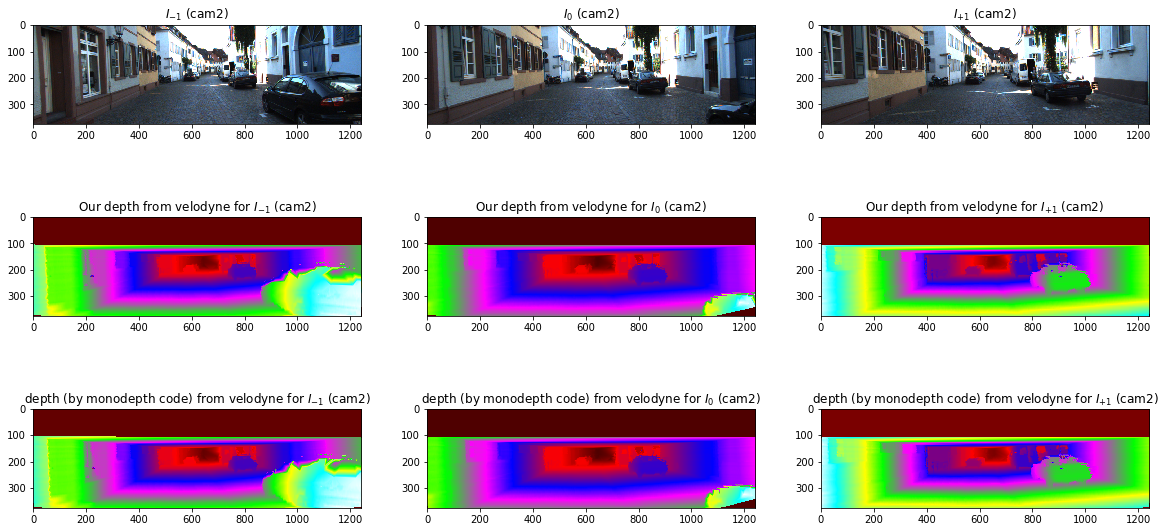

In [19]:
    # Change this to the directory where you store KITTI data
    my_base_path = '/media/ccjData3_HDD/datasets/kitti_raw/rawdata'
    # Specify the dataset to load
    date = '2011_09_26'
    drive = '0093'

    # Load the data. Optionally, specify the frame range to load.
    my_dataset = pykitti.raw(my_base_path, date, drive, 
                            #frames=range(0, 20, 5)
                            )
    
    # neural rgb2d paper:
    delta_t = 5
    cur_t = 2*delta_t
    #local_window = [cur_t - 2*delta_t, cur_t - delta_t, cur_t, cur_t + delta_t, cur_t + 2*delta_t]
    #names_local = [r'$I_{-2}$', r'$I_{-1}$', r'$I_{0}$', r'$I_{+1}$', r'$I_{+2}$']
    local_window = [cur_t - delta_t, cur_t, cur_t + delta_t]
    names_local = [r'$I_{-1}$', r'$I_{0}$', r'$I_{+1}$']
    frames_local = [my_dataset.get_cam2(idx) for idx in local_window]
    #source_frames = [my_dataset.get_cam2(idx) for idx in local_window if idx != cur_t]
    #ref_frame = my_dataset.get_cam2(cur_t)

    # Read velodyne [x,y,z,reflectance] scan at the specified index
    velo_pts_local = [my_dataset.get_velo(idx) for idx in local_window]


    f, ax = plt.subplots(3, len(local_window), 
                        figsize=(20, 10)
                        )
    for i, n in enumerate(names_local):
        ax[0, i].imshow(frames_local[i])
        ax[0, i].set_title('%s (cam2)'%n)
    
    T_velo_to_cam2_local = [my_dataset.calib.T_cam0_velo for idx in local_window]
    K_cam2_local = [my_dataset.calib.K_cam2 for idx in local_window]

    #f2 = plt.figure()
    #ax2 = f2.add_subplot(100+10*len(local_window)+len(local_window))
    #f2, ax2 = plt.subplots(1, len(local_window))
    
    my_calib_path = os.path.join(my_base_path, date)
    my_drive = date + '_drive_' + drive + '_sync'
    my_velo_path = os.path.join(my_base_path, date, my_drive, 'velodyne_points/data')
    velo_files_local = [pjoin(my_velo_path, '%010d.bin'%idx) for idx in local_window]
    for i, n in enumerate(names_local):
        imgW, imgH = frames_local[i].size # due to PIL Image
        depth, count, pts = get_depth_from_velodyne(imgH, imgW, 
        T_velo_to_cam2_local[i], 
        K_cam2_local[i],
        velo_pts_local[i], # list of points [x,y,z,reflectance]
        interp= True
        )
        _MIN_DEPTH = 1e-3
        _MAX_DEPTH= 80 # in meters
        depth[depth < _MIN_DEPTH] = _MAX_DEPTH
        #ax[1, i].imshow(depth, cmap='gray')
        ax[1, i].imshow( kitti_colormap(1.0/depth)) # 1/depth to mimic the kitti color for disparity map; 
        ax[1, i].set_title('Our depth from velodyne for %s (cam2)'%n)
        #ax[2, i].imshow(count, cmap='gray')
        #ax[2, i].set_title('count depth from velodyne for %s (cam2)'%n)
        
        _, depth_good = generate_depth_map(
            calib_dir = pjoin(my_base_path, date), 
            velo_file_name = velo_files_local[i], 
            im_shape = [imgH, imgW], 
            cam=2, 
            #interp=False, 
            interp=True, 
            vel_depth=False)
        _MIN_DEPTH = 1e-3
        _MAX_DEPTH= 80 # in meters
        depth_good[depth_good < _MIN_DEPTH] = _MAX_DEPTH
        ax[2, i].imshow(kitti_colormap(1.0/depth_good))
        ax[2, i].set_title('depth (by monodepth code) from velodyne for %s (cam2)'%n)
        
        if 0:
            x_img = [p[0] for p in pts]
            y_img = [p[1] for p in pts]
            print (pts[15:20])
            print ("plot ax2[0,%d]"%i)
            ax2[i].scatter(x= x_img, y = y_img )
            ax2[i].set_title('scatter of img coordinates from velodyne for %s (cam2)'%n)
    plt.show()

- Let us shown the depth without interpolation (Note: interpolation will fill the holes in depth maps).

[***] loading cam2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_cam_to_cam.txt
[***] loading velo2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_velo_to_cam.txt
[ 7.533745e-03 -9.999714e-01 -6.166020e-04  1.480249e-02  7.280733e-04
 -9.998902e-01  9.998621e-01  7.523790e-03  1.480755e-02]
[***] loading cam2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_cam_to_cam.txt
[***] loading velo2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_velo_to_cam.txt
[ 7.533745e-03 -9.999714e-01 -6.166020e-04  1.480249e-02  7.280733e-04
 -9.998902e-01  9.998621e-01  7.523790e-03  1.480755e-02]
[***] loading cam2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_cam_to_cam.txt
[***] loading velo2cam file  /media/ccjData3_HDD/datasets/kitti_raw/rawdata/2011_09_26/calib_velo_to_cam.txt
[ 7.533745e-03 -9.999714e-01 -6.166020e-04  1.480249e-02  7.280733e-04
 -9.998902e-01  9.99862

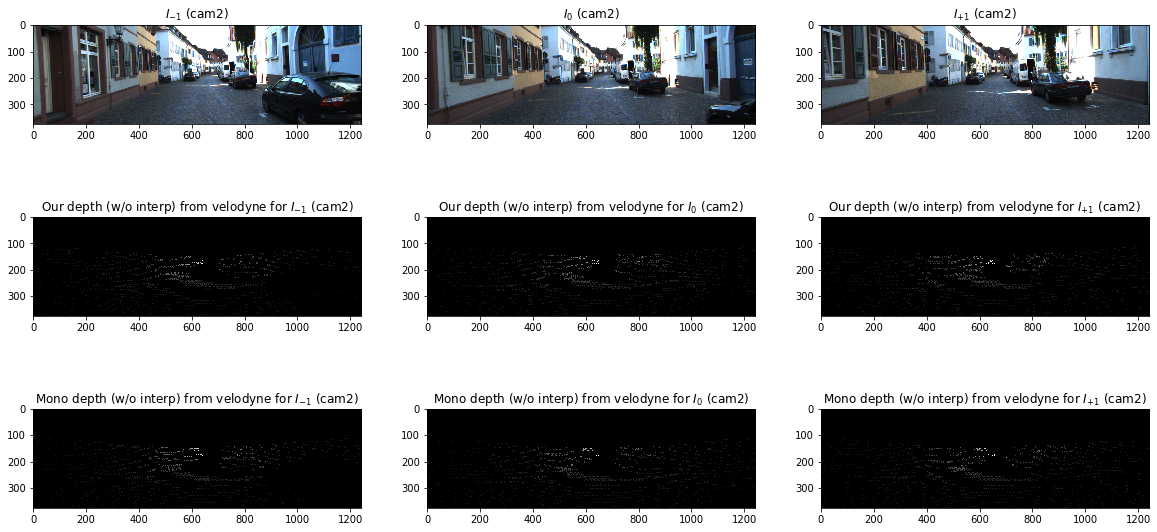

In [17]:
    f, ax = plt.subplots(3, len(local_window), 
                        figsize=(20, 10)
                        )
    for i, n in enumerate(names_local):
        ax[0, i].imshow(frames_local[i])
        ax[0, i].set_title('%s (cam2)'%n)
    
    
    for i, n in enumerate(names_local):
        imgW, imgH = frames_local[i].size # due to PIL Image
        depth, count, pts = get_depth_from_velodyne(imgH, imgW, 
        T_velo_to_cam2_local[i], 
        K_cam2_local[i],
        velo_pts_local[i], # list of points [x,y,z,reflectance]
        interp= False
        )
        ax[1, i].imshow(depth, cmap='gray')
        ax[1, i].set_title('Our depth (w/o interp) from velodyne for %s (cam2)'%n)
        #ax[2, i].imshow(count, cmap='gray')
        #ax[2, i].set_title('count depth from velodyne for %s (cam2)'%n)
        
        depth_good = generate_depth_map(
            calib_dir = pjoin(my_base_path, date), 
            velo_file_name = velo_files_local[i], 
            im_shape = [imgH, imgW], 
            cam=2, 
            interp=False,
            vel_depth=False)
        ax[2, i].imshow(depth_good, cmap='gray')
        ax[2, i].set_title('Mono depth (w/o interp) from velodyne for %s (cam2)'%n)
    plt.show()